Импорт библиотек. Список библиотек находится в файле **requirements.txt**

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import GridSearchCV,train_test_split,cross_val_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc

import scipy.stats
from scipy import stats
from sklearn.ensemble import IsolationForest
from scipy.stats import norm, skew #for some statistics
from scipy.stats import normaltest

from IPython.display import Image
from IPython.core.display import HTML

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as acc
from mlxtend.feature_selection import SequentialFeatureSelector as sfs



import os
import warnings
from factor_analyzer import FactorAnalyzer
from sklearn.multioutput import MultiOutputClassifier
warnings.filterwarnings('ignore')

## 1. Загрузка данных. 
Файл лежит в репозитории.

In [8]:
data = pd.read_csv('diabetes.csv')
data = data.sample(frac=1)

Приведем к типу вещественного числа (**float**) для удоства дальнейших вычислений

In [9]:
data1 = data.replace(',','.', regex=True)
data.iloc[:, 8:12] = data1.iloc[:, 8:12].astype(float)
data.iloc[:, 14:16] = data1.iloc[:, 14:16].astype(float)
data.iloc[:, 18:24] = data1.iloc[:, 18:24].astype(float)
X = data.iloc[:, 4:25]
Y = data.iloc[:, 1:4]

Ниже представлена краткая информация о полученных данных

In [10]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
296,2,146,70,38,360,28.0,0.337,29,1.0
81,2,74,0,0,0,0.0,0.102,22,0.0
312,2,155,74,17,96,26.6,0.433,27,1.0
653,2,120,54,0,0,26.8,0.455,27,0.0
88,15,136,70,32,110,37.1,0.153,43,1.0


Последние пять строк в данных:

In [11]:
data.tail()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
276,7,106,60,24,0,26.5,0.296,29,1.0
556,1,97,70,40,0,38.1,0.218,30,0.0
42,7,106,92,18,0,22.7,0.235,48,0.0
36,11,138,76,0,0,33.2,0.420,35,0.0
178,5,143,78,0,0,45.0,0.190,47,0.0


Ниже представлена информация о типах данных в датасете:

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 768 entries, 296 to 178
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    float64
dtypes: float64(3), int64(6)
memory usage: 60.0 KB


## 2. Предварительный анализ данных

Найдем пропуски в данных:


In [14]:
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Видим, что пропусков данных нет. Иначе во 2 колонке были бы ненулевые значения

Найдем аномальные значения.

**Прежде всего**, необходимо получить список столбцов (параметров) из нашего датасета. Это необходимо, так как на картинках подписи могут заехать друг на друга

In [22]:
columns = list(data.columns.values)
columns

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Outcome']

<Axes: >

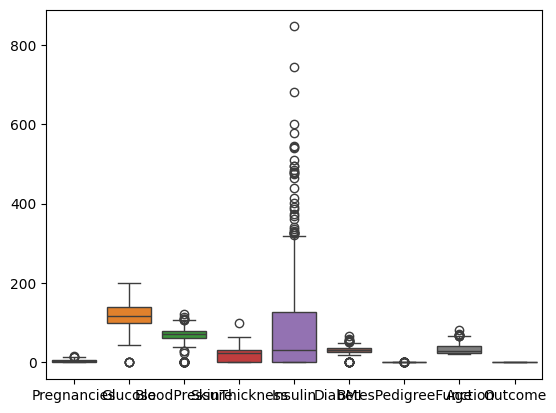

In [23]:
sns.boxplot(data=data)

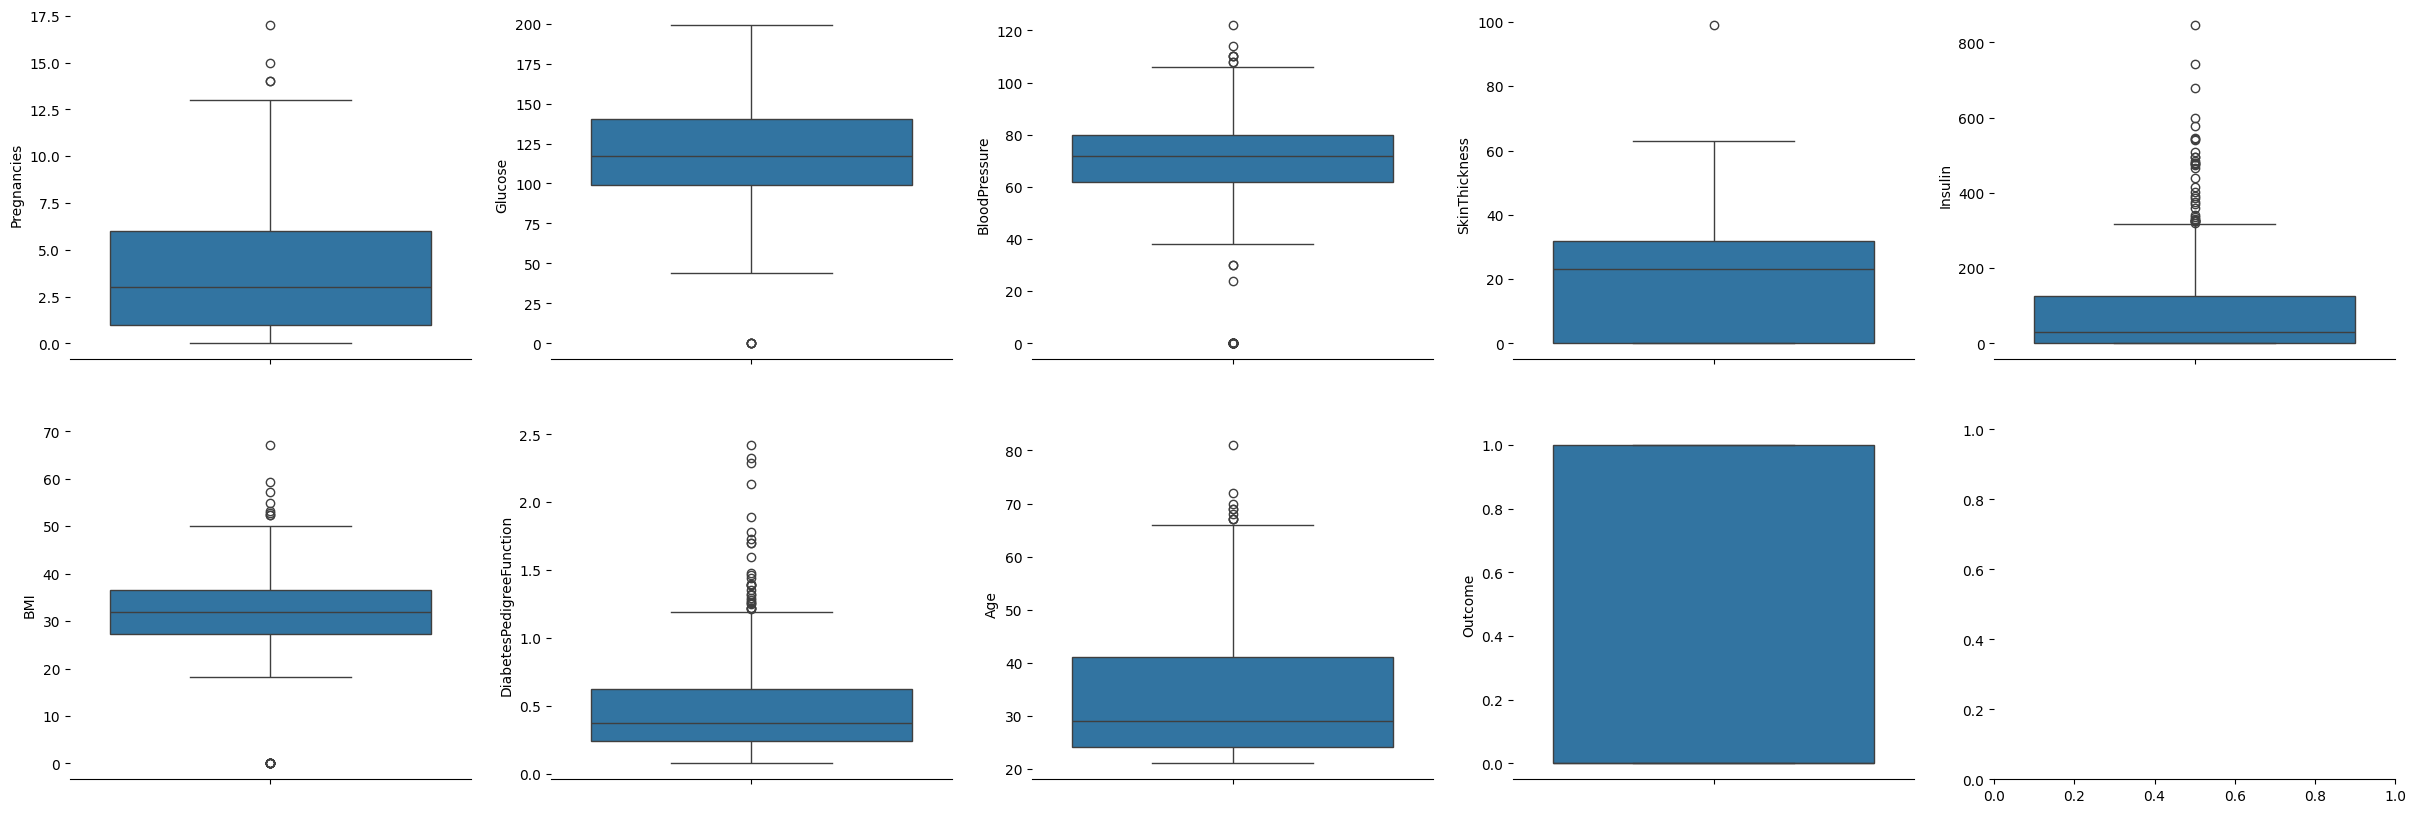

In [44]:
f, axes = plt.subplots(2, 5, figsize=(30, 10))
sns.despine(left=True)
for i in range(0, len(columns)):
    sns.boxplot(data = data[columns[i]], ax=axes[i//5, i%5])

Точками показаны выбросы. Интервалы отображают минимум и максимум, а прямоугольник медиану. В данных слишком много выбросов

## 3.Вычисляем основные статистические характеристики


In [46]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Строка count - количество записей

mean - математическое ожидание (среднее)

std - среднее отклонение

min, max - минимальное и максимальное значение соответвственно

25%, 50%, 75% - отклонения от среднего

Вычисляем среднеквадратичное отклонение:

In [47]:
data.describe().iloc[2, :].pow(0.5)

Pregnancies                  1.835641
Glucose                      5.654433
BloodPressure                4.399524
SkinThickness                3.994023
Insulin                     10.735176
BMI                          2.807875
DiabetesPedigreeFunction     0.575611
Age                          3.429319
Outcome                      0.690617
Name: std, dtype: float64

Поиск эксцессы, ассиметрии:

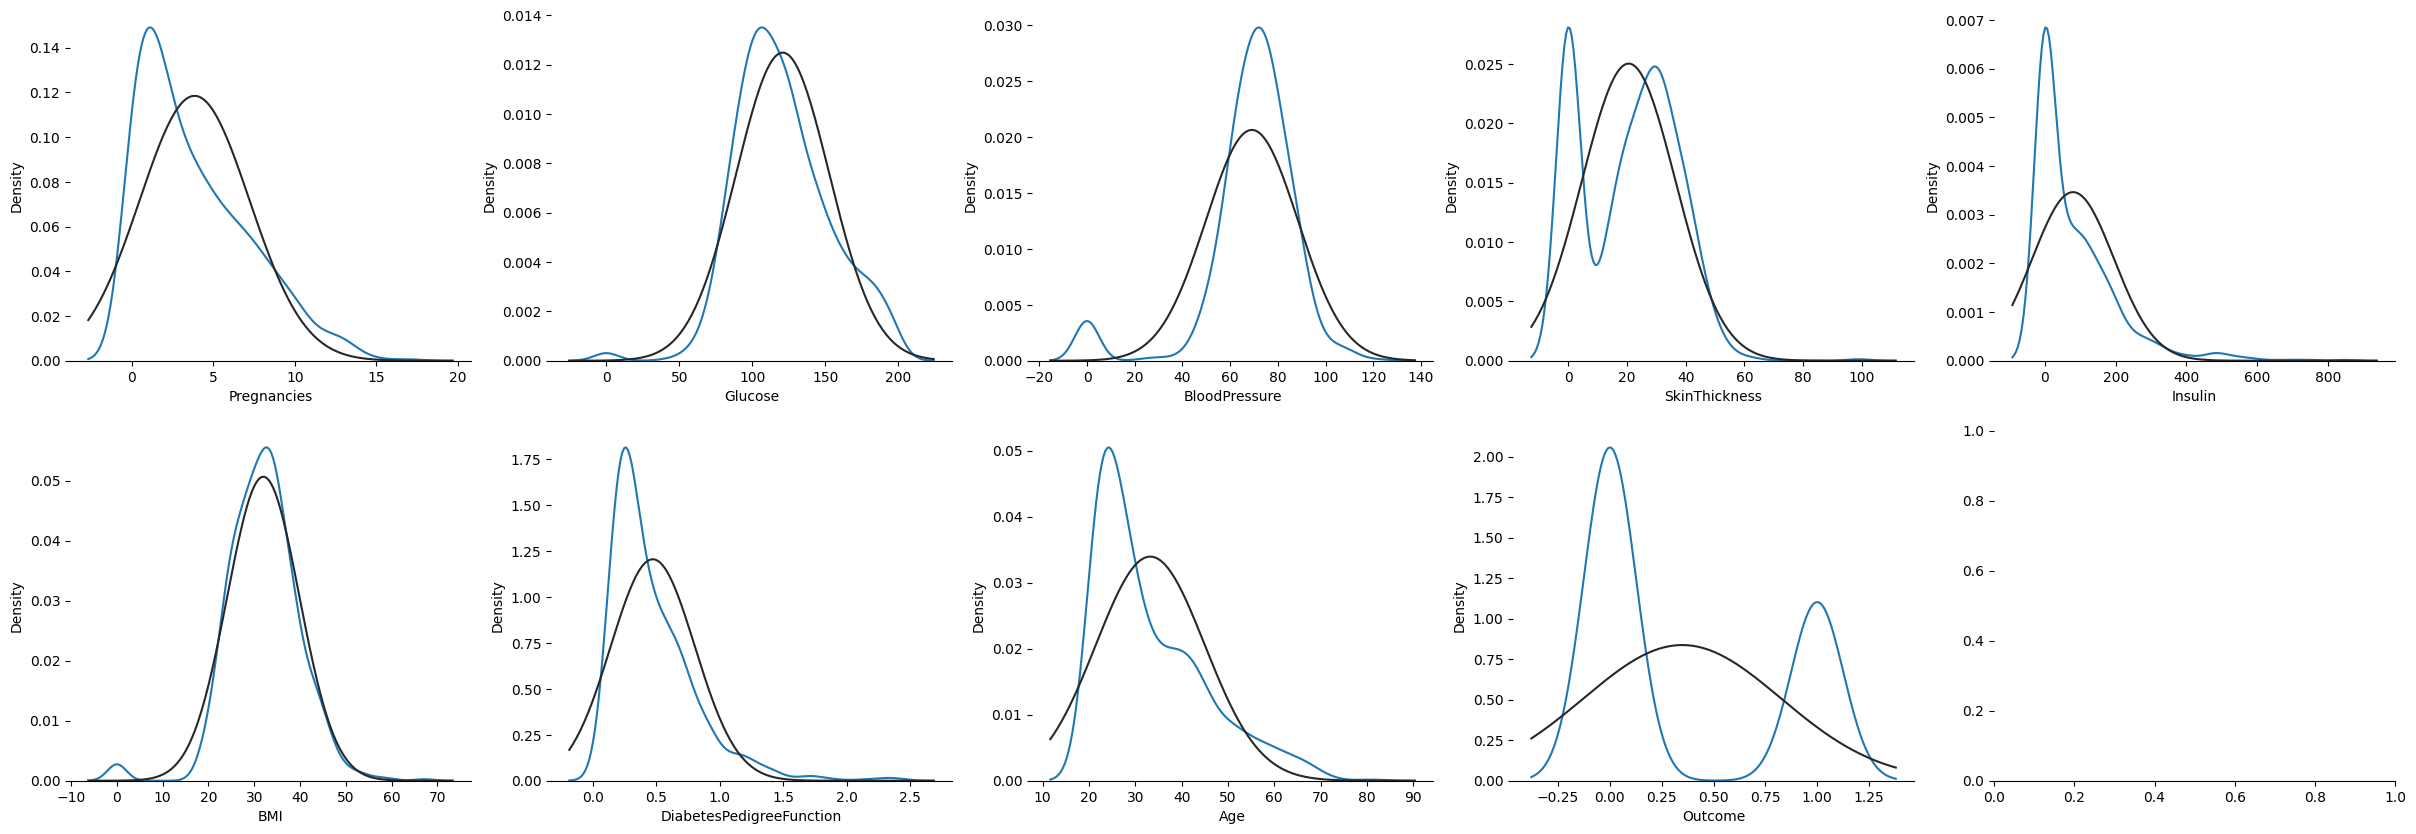

In [49]:
f, axes = plt.subplots(2, 5, figsize=(30, 10))
sns.despine(left=True)
for i in range(0, len(columns)):
    sns.distplot(data[columns[i]], fit=norm, hist=False, ax=axes[i//5, i%5])

Графики эксцессы, ассиметрии. Синим отображён график распределения, чёрным отображено нормальное распределение.

Поиск числовых значений ассиметрии и эксцессы:

In [51]:
for i in range(0, len(columns)):
    print("Skewness and Kurtosis of " + columns[i] + " : %f , %f" % (data[columns[i]].skew(), data[columns[i]].kurt()))

Skewness and Kurtosis of Pregnancies : 0.901674 , 0.159220
Skewness and Kurtosis of Glucose : 0.173754 , 0.640780
Skewness and Kurtosis of BloodPressure : -1.843608 , 5.180157
Skewness and Kurtosis of SkinThickness : 0.109372 , -0.520072
Skewness and Kurtosis of Insulin : 2.272251 , 7.214260
Skewness and Kurtosis of BMI : -0.428982 , 3.290443
Skewness and Kurtosis of DiabetesPedigreeFunction : 1.919911 , 5.594954
Skewness and Kurtosis of Age : 1.129597 , 0.643159
Skewness and Kurtosis of Outcome : 0.635017 , -1.600930


Вычисление доверительных интервалов:

In [52]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [53]:
for i in range(0, len(columns)):
    m, mMinus, mPlus = mean_confidence_interval(data[columns[i]], confidence=0.95)
    print("Доверительный интервал для " + columns[i] + " : Среднее: %f с интервалом(%f , %f)" % (m, mMinus, mPlus))

Доверительный интервал для Pregnancies : Среднее: 3.845052 с интервалом(3.606365 , 4.083739)
Доверительный интервал для Glucose : Среднее: 120.894531 с интервалом(118.629722 , 123.159340)
Доверительный интервал для BloodPressure : Среднее: 69.105469 с интервалом(67.734383 , 70.476555)
Доверительный интервал для SkinThickness : Среднее: 20.536458 с интервалом(19.406469 , 21.666448)
Доверительный интервал для Insulin : Среднее: 79.799479 с интервалом(71.636068 , 87.962890)
Доверительный интервал для BMI : Среднее: 31.992578 с интервалом(31.434097 , 32.551060)
Доверительный интервал для DiabetesPedigreeFunction : Среднее: 0.471876 с интервалом(0.448406 , 0.495346)
Доверительный интервал для Age : Среднее: 33.240885 с интервалом(32.407839 , 34.073932)
Доверительный интервал для Outcome : Среднее: 0.348958 с интервалом(0.315173 , 0.382744)


## 4. Оценка нормальности распределения ИСД (их подчинения нормальному закону);

**Оценка нормальности распределения с помощью функции normaltest.**

In [56]:
for i in range(0, len(columns)):
    stat, p = normaltest(data[columns[i]])
    print('Оценка нормальности распределения для ' + columns[i] + '. Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Подчиняется нормальному закону распределения')
    else:
        print('Не подчиняется нормальному закону распределения')

Оценка нормальности распределения для Pregnancies. Statistics=80.164, p=0.000
Не подчиняется нормальному закону распределения
Оценка нормальности распределения для Glucose. Statistics=12.385, p=0.002
Не подчиняется нормальному закону распределения
Оценка нормальности распределения для BloodPressure. Statistics=305.887, p=0.000
Не подчиняется нормальному закону распределения
Оценка нормальности распределения для SkinThickness. Statistics=17.345, p=0.000
Не подчиняется нормальному закону распределения
Оценка нормальности распределения для Insulin. Statistics=387.578, p=0.000
Не подчиняется нормальному закону распределения
Оценка нормальности распределения для BMI. Statistics=86.142, p=0.000
Не подчиняется нормальному закону распределения
Оценка нормальности распределения для DiabetesPedigreeFunction. Statistics=321.839, p=0.000
Не подчиняется нормальному закону распределения
Оценка нормальности распределения для Age. Statistics=119.878, p=0.000
Не подчиняется нормальному закону распредел

**Видим, что данные не подчиняются нормальному распределнию**

## 6. Вычисление парных коэффициентов линейной корреляции.

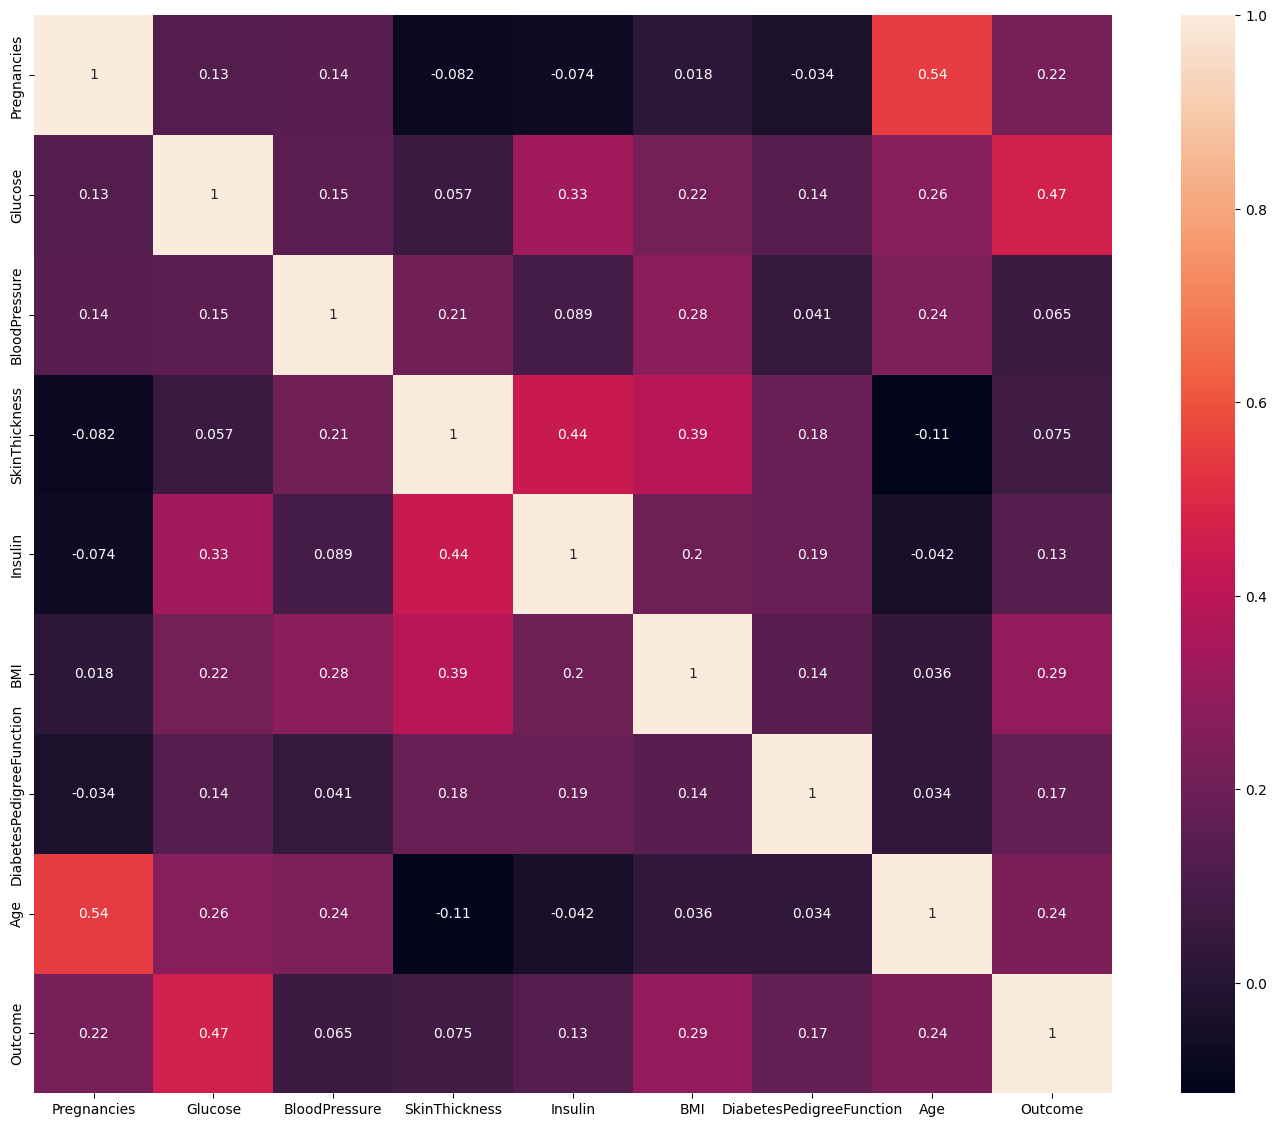

In [57]:
corrmat = data.corr()
f, ax = plt.subplots(figsize=(18, 14))
sns.heatmap(corrmat, square=True, annot = True);

**Из полученной визуализации карты коррлеции делаем следующие выводы:**
1. Показатель ***Pregnacies*** (Беременность) слабо коррелирует с большинством показателей, кроме ***Age*** (возраст)
2. Показатель ***Glucose*** (Уровень глюкозы) имеет сильную (относительно других показателей) связь с показателем ***Outcome*** (Исход)
3. На показатель ***Outcome*** (Исход) сильнее всего влияют показатели: ***Glucose*** (Уровень глюкозы) ***BMI*** (индекс массы тела) ***Age*** (возраст) ***Pregnacies*** (Беременность). Кроме этого стоит учитывать, что ***Pregnacies*** и ***Age*** имеют взаимный высокий показатель корреляции
4. Наивысший показатель обратной корреляции у ***Age*** и ***SkinThickness*** (толщина кожи)


***Корреляционный анализ:***
Будем отбирать факторы с помощью функции stats.pearsonr.

Функция возвращает коэффицент корреляции(Изображён выше) и уровень значимости. Уровень значимостио отвечает за вероятность гипотезы о том, что наша корреляция "случайна". Если уровень значимости меньше чем наша переменная alpha, то можно отбросить эту гипотезу и принять данный фактор.

Корреляционный анализ для ***Pregnacies***:

In [ ]:
alpha = 0.05